# Incident Visualization Analysis

이 노트북은 SAN_BERNARDINO 데이터셋에서 사고 상황에서의 예측 성능을 시각적으로 분석합니다.

## 목표:
1. 사고 메타데이터와 테스트 결과 로드
2. 사고별 예측 성능 시각화
3. 노드별 사고 영향 분석
4. 전체 vs 사고별 성능 비교


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# BasicTS 경로 추가
sys.path.append('/home/uqtyu7/github/BasicTS')

# 설정
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("라이브러리 로드 완료!")


라이브러리 로드 완료!


In [2]:
incidents = pd.read_csv('/home/uqtyu7/github/BasicTS/datasets/xtraffic/SAN_BERNARDINO/incident_metadata_2023.csv')
print(incidents.head())

   incident_id  station_id  sensor_idx        incident_time  incident_slot  \
0     21889665      825819         277  2023-09-12 14:49:00          73329   
1     21501115      825818         278  2023-03-02 18:44:00          17504   
2     21497625      825818         278  2023-03-01 09:19:00          17103   
3     21495226      825818         278  2023-02-28 12:40:00          16856   
4     21457956      825818         278  2023-02-10 13:12:00          11678   

   post_incident_start_slot  input_start_slot  input_end_slot  \
0                     73330             73318           73330   
1                     17505             17493           17505   
2                     17104             17092           17104   
3                     16857             16845           16857   
4                     11679             11667           11679   

   output_start_slot  output_end_slot  distance incident_type  \
0              73330            73336     0.003        Hazard   
1         

In [30]:
def load_incident_data():
    """사고 메타데이터와 테스트 결과를 로드합니다."""
    
    # 경로 설정
    base_path = Path('/home/uqtyu7/github/BasicTS')
    # MODEL_PATH = "STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_100_12_12/1a8370b513fd6ae305fa404dd0589d21/"
    MODEL_PATH = "STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.16_100_12_12/fd3cb5e08269a1aabd8d9d6877e31ee6"
    # MODEL_PATH = "STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_a_1.0_b_0.3_100_12_12/d580669c7b4d25998b469114793b58c7/"
    incident_metadata_path = base_path / 'datasets/xtraffic/SAN_BERNARDINO/incident_metadata_2023.csv'
    test_results_path = base_path / f'checkpoints/{MODEL_PATH}/test_results.npz'
    test_metrics_path = base_path / f'checkpoints/{MODEL_PATH}/test_metrics.json'
    incident_metrics_path = base_path / f'checkpoints/{MODEL_PATH}/test_incident_metrics.json'
    
    # 데이터 로드
    print("데이터 로딩 중...")
    
    # 사고 메타데이터
    incident_df = pd.read_csv(incident_metadata_path)
    print(f"사고 메타데이터: {len(incident_df)}개 사고")
    
    # 테스트 결과
    test_results = np.load(test_results_path)
    predictions = test_results['prediction']  # (N, horizon, num_nodes)
    targets = test_results['target']          # (N, horizon, num_nodes)
    inputs = test_results['inputs']           # (N, input_len, num_nodes)
    
    print(f"테스트 결과: {predictions.shape}")
    
    # 메트릭 로드
    with open(test_metrics_path, 'r') as f:
        test_metrics = json.load(f)
    
    with open(incident_metrics_path, 'r') as f:
        incident_metrics = json.load(f)
    
    print("데이터 로딩 완료!")
    
    return {
        'incident_df': incident_df,
        'predictions': predictions,
        'targets': targets,
        'inputs': inputs,
        'test_metrics': test_metrics,
        'incident_metrics': incident_metrics
    }

# 데이터 로드
data = load_incident_data()


데이터 로딩 중...
사고 메타데이터: 25015개 사고
테스트 결과: (21001, 12, 893, 1)
데이터 로딩 완료!


In [31]:
def filter_incident_samples(incident_df, test_start_idx=84096, test_end_idx=105120):
    """테스트 범위 내의 사고 샘플들을 필터링합니다."""
    
    # 테스트 범위 내 사고만 추출 (input_start_slot 기준)
    incidents_in_test = incident_df[
        (incident_df['input_start_slot'] >= test_start_idx) & 
        (incident_df['input_start_slot'] < test_end_idx - 24)
    ].copy()
    
    # 테스트 데이터의 상대적 인덱스로 변환 (input_start_slot 기준)
    incidents_in_test['test_relative_idx'] = incidents_in_test['input_start_slot'] - test_start_idx
    
    print(f"테스트 범위 내 사고: {len(incidents_in_test)}개")
    print(f"Input 시작 슬롯 범위: {incidents_in_test['input_start_slot'].min()} - {incidents_in_test['input_start_slot'].max()}")
    print(f"상대적 인덱스 범위: {incidents_in_test['test_relative_idx'].min()} - {incidents_in_test['test_relative_idx'].max()}")
    
    return incidents_in_test

# 사고 샘플 필터링
base_path = Path('/home/uqtyu7/github/BasicTS')
incident_metadata_path = base_path / 'datasets/xtraffic/SAN_BERNARDINO/incident_metadata_2023.csv'
incident_df= pd.read_csv(incident_metadata_path)
incidents_in_test = filter_incident_samples(incident_df)

print(f"incident 갯수 : {len(incidents_in_test)}")



테스트 범위 내 사고: 4852개
Input 시작 슬롯 범위: 84128 - 105095
상대적 인덱스 범위: 32 - 20999
incident 갯수 : 4852


In [33]:
def plot_multiple_incidents_with_same_time(incidents, data, horizon=12):
    """여러 사고를 한 번에 비교 시각화합니다 (Same Time of Day 데이터 포함)."""
    
    n_incidents = len(incidents)
    fig, axes = plt.subplots(n_incidents, 2, figsize=(15, 4*n_incidents))
    
    if n_incidents == 1:
        axes = axes.reshape(1, -1)
    
    for i, row in enumerate(incidents.iterrows()):
        index, incident = row
        incident_idx = incident['incident_id']
        test_idx = incident['test_relative_idx']
        incident_node = incident['sensor_idx']  # sensor_idx를 노드로 사용
        incident_slot = incident['incident_slot']  # 절대 슬롯 번호
        
        # 데이터 추출
        input_seq = data['inputs'][test_idx]
        target_seq = data['targets'][test_idx]
        pred_seq = data['predictions'][test_idx]
        
        input_node = input_seq[:, incident_node]
        target_node = target_seq[:, incident_node]
        pred_node = pred_seq[:, incident_node]
        
        # 같은 시간대의 평소 데이터 찾기 (288 = 24시간 * 12개/시간) - 10개
        same_time_indices = []
        for offset in [-288*5, -288*4, -288*3, -288*2, -288, 288, 288*2, 288*3, 288*4, 288*5]:
            same_time_slot = incident_slot + offset
            # 테스트 범위 내에 있는지 확인
            if 84096 <= same_time_slot < 105120:
                same_time_test_idx = same_time_slot - 84096
                if 0 <= same_time_test_idx < len(data['targets']):
                    same_time_indices.append(same_time_test_idx)
        
        # Input plot
        input_time = np.arange(-len(input_node), 0)
        axes[i, 0].plot(input_time, input_node, 'b-', linewidth=3, label='Incident Day')
        axes[i, 0].axvline(x=-1, color='red', linestyle='--', alpha=0.7, label='Incident Time')
        
        # 같은 시간대의 평소 Input 데이터들 (10개, legend 없음)
        colors = plt.cm.viridis(np.linspace(0, 1, len(same_time_indices)))
        for j, same_time_idx in enumerate(same_time_indices):
            same_time_input = data['inputs'][same_time_idx][:, incident_node]
            axes[i, 0].plot(input_time, same_time_input, '--', color=colors[j], alpha=0.6, linewidth=1)
        
        axes[i, 0].set_title(f'Incident #{incident_idx} (Node {incident_node}) - Input')
        axes[i, 0].set_ylabel('Traffic Flow')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)

        
        # Output plot (12 timestamps)
        output_time = np.arange(0, horizon)

        axes[i, 1].plot(output_time, target_node, 'g-', linewidth=3, marker='o', label='Actual', markersize=6)
        axes[i, 1].plot(output_time, pred_node, 'r--', linewidth=3, marker='s', label='Prediction', markersize=6)
        axes[i, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Incident Time')
        
        # 같은 시간대의 평소 Output 데이터들 (10개, legend 없음)
        same_time_maes = []
        for j, same_time_idx in enumerate(same_time_indices):
            same_time_target = data['targets'][same_time_idx][:, incident_node]
            same_time_pred = data['predictions'][same_time_idx][:, incident_node]
            axes[i, 1].plot(output_time, same_time_target, '--', color=colors[j], alpha=0.6, linewidth=1)
            
            # 평상시 MAE 계산
            same_time_mae = np.mean(np.abs(same_time_target - same_time_pred))
            same_time_maes.append(same_time_mae)

        axes[i, 1].set_title(f'Incident #{incident_idx} (Node {incident_node}) - Output (12 timestamps)')
        axes[i, 1].set_ylabel('Traffic Flow')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Input과 Output의 y-axis 범위를 동일하게 설정
        # 모든 데이터 포인트 수집
        all_input_data = [input_node]
        all_output_data = [target_node, pred_node]
        
        # Same time of day 데이터 추가
        for j, same_time_idx in enumerate(same_time_indices):
            same_time_input = data['inputs'][same_time_idx][:, incident_node]
            same_time_target = data['targets'][same_time_idx][:, incident_node]
            all_input_data.append(same_time_input)
            all_output_data.append(same_time_target)
        
        # 전체 데이터 범위 계산
        all_input_values = np.concatenate(all_input_data)
        all_output_values = np.concatenate(all_output_data)
        all_values = np.concatenate([all_input_values, all_output_values])
        
        y_min = np.min(all_values)
        y_max = np.max(all_values)
        y_margin = (y_max - y_min) * 0.05  # 5% 여유분
        
        # y-axis 범위 설정
        axes[i, 0].set_ylim(y_min - y_margin, y_max + y_margin)
        axes[i, 1].set_ylim(y_min - y_margin, y_max + y_margin)
        
        # 오차 표시 (사고시 MAE + 평상시 MAE 평균)
        incident_mae = np.mean(np.abs(target_node - pred_node))
        normal_mae_avg = np.mean(same_time_maes) if same_time_maes else 0
        
        text_content = f'Incident MAE: {incident_mae:.3f}\nNormal MAE: {normal_mae_avg:.3f}'
        axes[i, 1].text(0.02, 0.98, text_content, transform=axes[i, 1].transAxes, 
                       verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()


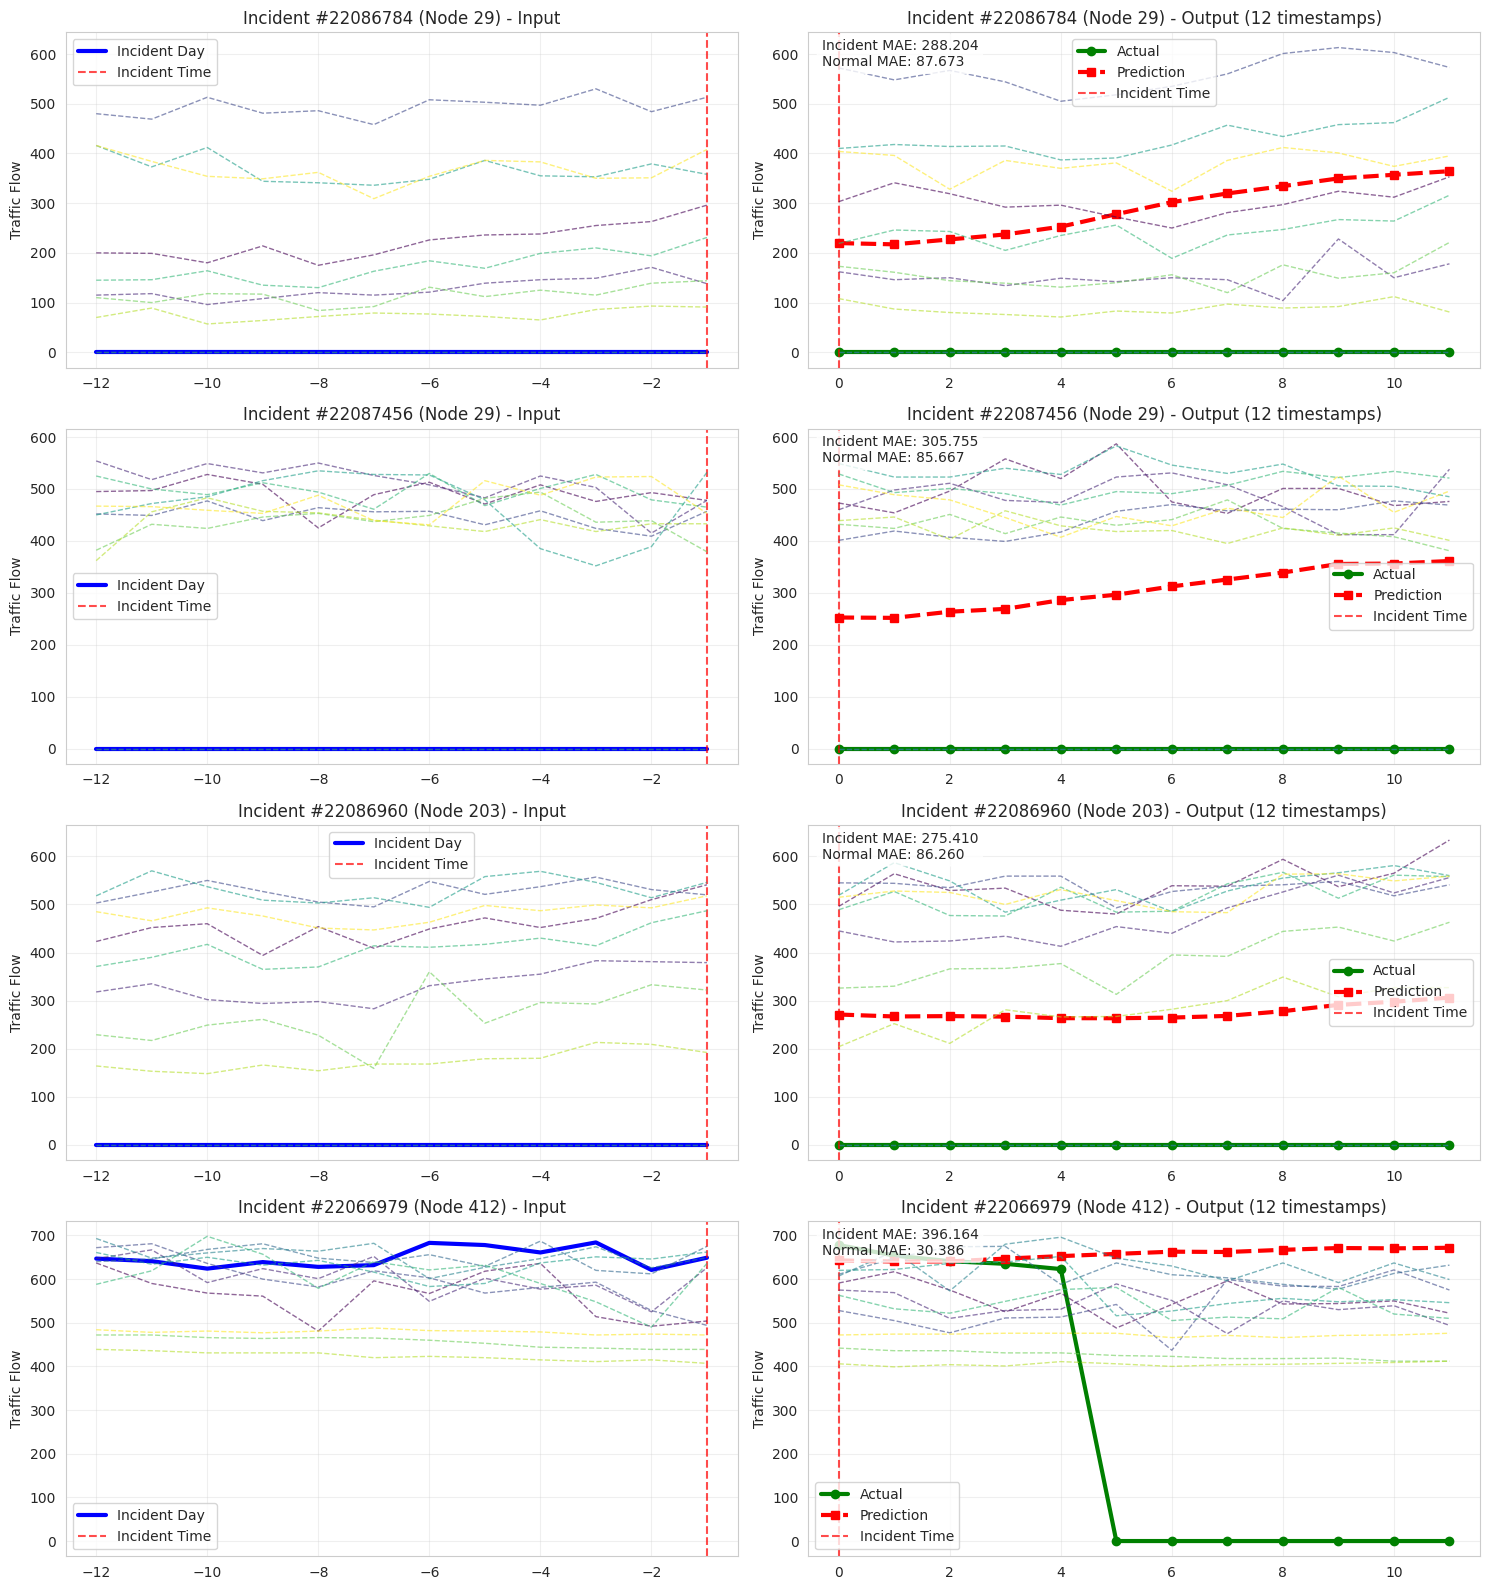

In [34]:
mae_differences = []
hazard_incidents = incidents_in_test[incidents_in_test['incident_type'] == 'Hazard']

for idx, row in hazard_incidents.iterrows():
    incident = row
    test_idx = incident['test_relative_idx']
    incident_node = incident['sensor_idx']
    incident_slot = incident['incident_slot']
    
    # 사고시 데이터
    target_node = data['targets'][test_idx][:, incident_node]
    pred_node = data['predictions'][test_idx][:, incident_node]
    incident_mae = np.mean(np.abs(target_node - pred_node))
    
    # 같은 시간대의 평상시 데이터들 찾기
    same_time_indices = []
    for offset in [-288*5, -288*4, -288*3, -288*2, -288, 288, 288*2, 288*3, 288*4, 288*5]:
        same_time_slot = incident_slot + offset
        if 84096 <= same_time_slot < 105120:
            same_time_test_idx = same_time_slot - 84096
            if 0 <= same_time_test_idx < len(data['targets']):
                same_time_indices.append(same_time_test_idx)
    
    # 평상시 MAE들 계산
    same_time_maes = []
    for same_time_idx in same_time_indices:
        same_time_target = data['targets'][same_time_idx][:, incident_node]
        same_time_pred = data['predictions'][same_time_idx][:, incident_node]
        same_time_mae = np.mean(np.abs(same_time_target - same_time_pred))
        same_time_maes.append(same_time_mae)
    
    normal_mae_avg = np.mean(same_time_maes) if same_time_maes else 0
    mae_difference = incident_mae - normal_mae_avg
    
    mae_differences.append({
        'index': idx,
        'incident_mae': incident_mae,
        'normal_mae': normal_mae_avg,
        'mae_difference': mae_difference
    })

# MAE 차이가 큰 상위 5개 선택
# mae_differences_df = pd.DataFrame(mae_differences)
# top_5_incidents = mae_differences_df.nlargest(5, 'mae_difference')
# top_5_indices = top_5_incidents['index'].tolist()

# target_incidents = incidents_in_test.loc[top_5_indices]

# 특정 incident list에 대해 표시
incident_id_list = [22066979, 22087456, 22086960, 22086784, 220887851]
target_incidents= incidents_in_test[incidents_in_test['incident_id'].isin(incident_id_list)]

# 선택된 사고들로 시각화
plot_multiple_incidents_with_same_time(target_incidents, data)

In [18]:
def compare_incident_metrics(model1_path, model2_path, model1_name="Model 1", model2_name="Model 2"):
    """두 모델의 사고별 성능을 비교하는 bar chart를 생성합니다."""
    
    # JSON 파일 로드
    with open(model1_path, 'r') as f:
        model1_metrics = json.load(f)
    
    with open(model2_path, 'r') as f:
        model2_metrics = json.load(f)
    
    # 사고 타입별 overall MAE 추출
    incident_types = set()
    for key in model1_metrics.keys():
        if key.endswith('_overall'):
            incident_type = key.replace('_overall', '')
            incident_types.add(incident_type)
    
    # 데이터 준비
    model1_maes = []
    model2_maes = []
    incident_labels = []
    
    for incident_type in sorted(incident_types):
        overall_key = f"{incident_type}_overall"
        if overall_key in model1_metrics and overall_key in model2_metrics:
            model1_mae = model1_metrics[overall_key]['MAE']
            model2_mae = model2_metrics[overall_key]['MAE']
            
            model1_maes.append(model1_mae)
            model2_maes.append(model2_mae)
            incident_labels.append(incident_type)
    
    # Bar chart 생성
    x = np.arange(len(incident_labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bars1 = ax.bar(x - width/2, model1_maes, width, label=model1_name, alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, model2_maes, width, label=model2_name, alpha=0.8, color='lightcoral')
    
    # 차이 표시
    for i, (mae1, mae2) in enumerate(zip(model1_maes, model2_maes)):
        diff = mae2 - mae1
        color = 'green' if diff < 0 else 'red'
        ax.text(i, max(mae1, mae2) + 0.5, f'{diff:+.2f}', 
                ha='center', va='bottom', color=color, fontweight='bold')
    
    # 그래프 설정
    ax.set_xlabel('Incident Type', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('Incident Type Performance Comparison (Overall MAE)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(incident_labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 값 표시
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 요약 통계
    print(f"\n=== Performance Summary ===")
    print(f"{'Incident Type':<15} {'Model 1 MAE':<12} {'Model 2 MAE':<12} {'Difference':<12} {'Better':<10}")
    print("-" * 70)
    
    for i, incident_type in enumerate(incident_labels):
        mae1 = model1_maes[i]
        mae2 = model2_maes[i]
        diff = mae2 - mae1
        better = model1_name if diff > 0 else model2_name
        print(f"{incident_type:<15} {mae1:<12.3f} {mae2:<12.3f} {diff:<12.3f} {better:<10}")
    
    # 전체 평균
    avg_mae1 = np.mean(model1_maes)
    avg_mae2 = np.mean(model2_maes)
    print("-" * 70)
    print(f"{'Average':<15} {avg_mae1:<12.3f} {avg_mae2:<12.3f} {avg_mae2-avg_mae1:<12.3f} {model1_name if avg_mae2 > avg_mae1 else model2_name:<10}")
    
    return {
        'incident_types': incident_labels,
        'model1_maes': model1_maes,
        'model2_maes': model2_maes,
        'model1_avg': avg_mae1,
        'model2_avg': avg_mae2
    }


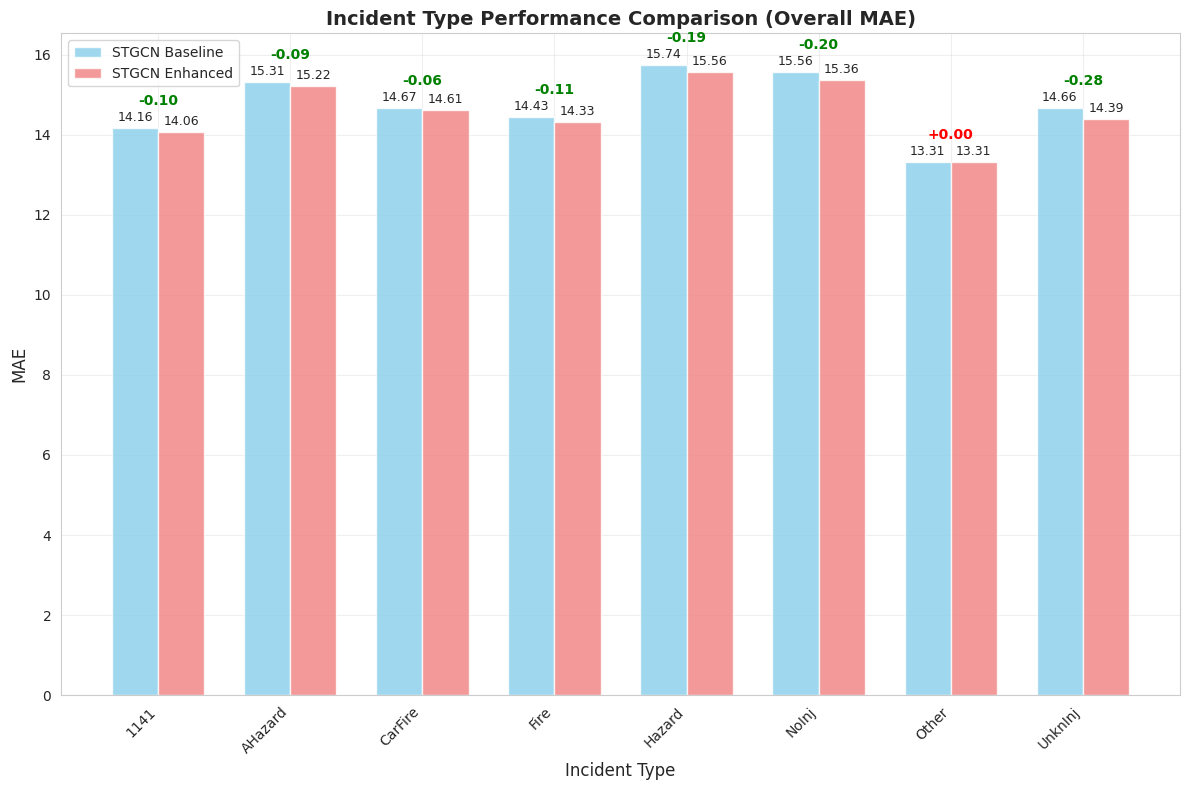


=== Performance Summary ===
Incident Type   Model 1 MAE  Model 2 MAE  Difference   Better    
----------------------------------------------------------------------
1141            14.159       14.062       -0.097       STGCN Enhanced
AHazard         15.305       15.218       -0.087       STGCN Enhanced
CarFire         14.674       14.610       -0.064       STGCN Enhanced
Fire            14.433       14.327       -0.106       STGCN Enhanced
Hazard          15.744       15.558       -0.186       STGCN Enhanced
NoInj           15.558       15.360       -0.198       STGCN Enhanced
Other           13.314       13.315       0.001        STGCN Baseline
UnknInj         14.664       14.385       -0.278       STGCN Enhanced
----------------------------------------------------------------------
Average         14.731       14.604       -0.127       STGCN Enhanced


In [12]:
# 사용 예시
# 두 모델의 사고별 성능 비교
base_path = Path('/home/uqtyu7/github/BasicTS')
model1_path = base_path / "checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_100_12_12/1a8370b513fd6ae305fa404dd0589d21/test_incident_metrics.json"
model2_path = base_path / "checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_SHARP_100_12_12/54be512680ada7d95880bf7c333db7a1/test_incident_metrics.json"  # 두 번째 모델 경로
# 비교 실행
results = compare_incident_metrics(
    model1_path=model1_path,
    model2_path=model2_path,
    model1_name="STGCN Baseline",
    model2_name="STGCN Enhanced"
)


In [13]:
def compare_general_metrics(model1_path, model2_path, model1_name="Model 1", model2_name="Model 2"):
    """두 모델의 일반적인 성능을 비교하는 bar chart를 생성합니다."""
    
    # JSON 파일 로드
    with open(model1_path, 'r') as f:
        model1_metrics = json.load(f)
    
    with open(model2_path, 'r') as f:
        model2_metrics = json.load(f)
    
    # horizon별 MAE 추출
    horizons = ['horizon_3', 'horizon_6', 'horizon_12', 'overall']
    model1_maes = []
    model2_maes = []
    horizon_labels = []
    
    for horizon in horizons:
        if horizon in model1_metrics and horizon in model2_metrics:
            model1_mae = model1_metrics[horizon]['MAE']
            model2_mae = model2_metrics[horizon]['MAE']
            
            model1_maes.append(model1_mae)
            model2_maes.append(model2_mae)
            horizon_labels.append(horizon.replace('horizon_', 'Horizon ').replace('overall', 'Overall'))
    
    # Bar chart 생성
    x = np.arange(len(horizon_labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars1 = ax.bar(x - width/2, model1_maes, width, label=model1_name, alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, model2_maes, width, label=model2_name, alpha=0.8, color='lightcoral')
    
    # 차이 표시
    for i, (mae1, mae2) in enumerate(zip(model1_maes, model2_maes)):
        diff = mae2 - mae1
        color = 'green' if diff < 0 else 'red'
        ax.text(i, max(mae1, mae2) + 0.3, f'{diff:+.2f}', 
                ha='center', va='bottom', color=color, fontweight='bold')
    
    # 그래프 설정
    ax.set_xlabel('Horizon', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.set_title('Model Performance Comparison (MAE by Horizon)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(horizon_labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 값 표시
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # 요약 통계
    print(f"\n=== Performance Summary ===")
    print(f"{'Horizon':<10} {'Model 1 MAE':<12} {'Model 2 MAE':<12} {'Difference':<12} {'Better':<10}")
    print("-" * 60)
    
    for i, horizon in enumerate(horizon_labels):
        mae1 = model1_maes[i]
        mae2 = model2_maes[i]
        diff = mae2 - mae1
        better = model1_name if diff > 0 else model2_name
        print(f"{horizon:<10} {mae1:<12.3f} {mae2:<12.3f} {diff:<12.3f} {better:<10}")
    
    # 전체 평균
    avg_mae1 = np.mean(model1_maes)
    avg_mae2 = np.mean(model2_maes)
    print("-" * 60)
    print(f"{'Average':<10} {avg_mae1:<12.3f} {avg_mae2:<12.3f} {avg_mae2-avg_mae1:<12.3f} {model1_name if avg_mae2 > avg_mae1 else model2_name:<10}")
    
    return {
        'horizons': horizon_labels,
        'model1_maes': model1_maes,
        'model2_maes': model2_maes,
        'model1_avg': avg_mae1,
        'model2_avg': avg_mae2
    }


In [ ]:
# 일반적인 metrics 비교 사용 예시
# 두 모델의 일반적인 성능 비교
base_path = Path('/home/uqtyu7/github/BasicTS')
model1_path = base_path / "checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_100_12_12/1a8370b513fd6ae305fa404dd0589d21"
model2_path = base_path / "checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_SHARP_100_12_12/54be512680ada7d95880bf7c333db7a1"  # 두 번째 모델 경로
# 비교 실행

model1_metrics_path = f"{model1_path}/test_metrics.json"
model2_metrics_path = f"{model2_path}/test_metrics.json"

# 일반적인 성능 비교 실행
general_results = compare_general_metrics(
    model1_path=model1_metrics_path,
    model2_path=model2_metrics_path,
    model1_name="STGCN Baseline",
    model2_name="STGCN CL_SHARP"
)


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_100_12_12/1a8370b513fd6ae305fa404dd0589d21/test_metrics.json'

In [ ]:
import re

overall_metrics_files= []
incidents_metrics_files = []
for root, dirs, files in os.walk("/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/"):

    pattern = r"SAN_BERNARDINO_CL_[0-9.]+_100_12_12"

    if re.search(pattern, root):
        overall_metrics_files.append(root + "/test_metrics.json")
        incidents_metrics_files.append(root + "/test_incident_metrics.json")



['/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.08_100_12_12/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.08_100_12_12/bed762f938b951827887d158c3c744c6/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.08_100_12_12/bed762f938b951827887d158c3c744c6/tensorboard/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.16_100_12_12/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.16_100_12_12/fd3cb5e08269a1aabd8d9d6877e31ee6/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.16_100_12_12/fd3cb5e08269a1aabd8d9d6877e31ee6/tensorboard/test_metrics.json', '/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/SAN_BERNARDINO_CL_0.02_100_12_12/test_metr

In [24]:
import re

# learning_rate 추출하여 로드
learning_rate_data = []
pattern = r"SAN_BERNARDINO_CL_([0-9.]+)_100_12_12"

for root, dirs, files in os.walk("/home/uqtyu7/github/BasicTS/checkpoints/STGCNChebGraphConv/xtraffic/"):
    match = re.search(pattern, root)
    if match:
        learning_rate = float(match.group(1))
        metrics_path = os.path.join(root, "test_metrics.json")
        if os.path.exists(metrics_path):
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
                overall_mae = metrics.get('overall', {}).get('MAE', None)
                if overall_mae is not None:
                    learning_rate_data.append({
                        'learning_rate': learning_rate,
                        'overall_mae': overall_mae
                    })
    if root.split("/")[-2] == "SAN_BERNARDINO_100_12_12":
        metrics_path = os.path.join(root, "test_metrics.json")
        learning_rate = 0
        if os.path.exists(metrics_path):
            with open(metrics_path, 'r') as f:
                metrics = json.load(f)
                overall_mae = metrics.get('overall', {}).get('MAE', None)
                if overall_mae is not None:
                    learning_rate_data.append({
                        'learning_rate': learning_rate,
                        'overall_mae': overall_mae
                    })







# DataFrame으로 변환
lr_df = pd.DataFrame(learning_rate_data).sort_values('learning_rate')
print(lr_df)

# 시각화
fig, ax = plt.subplots(figsize=(12, 7))

# Line plot
ax.plot(lr_df['learning_rate'], lr_df['overall_mae'], 
        marker='o', linewidth=2.5, markersize=10, 
        color='steelblue', markerfacecolor='lightcoral', markeredgewidth=2)

# 각 점에 값 표시
for _, row in lr_df.iterrows():
    ax.text(row['learning_rate'], row['overall_mae'] + 0.1, 
            f'{row["overall_mae"]:.3f}', ha='center', va='bottom', 
            fontsize=10, fontweight='bold')

# 그래프 설정
ax.set_xlabel('Learning Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Overall MAE', fontsize=14, fontweight='bold')
ax.set_title('Overall MAE vs Learning Rate', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xscale('log')

plt.tight_layout()
plt.show()

# 요약 통계
print("\n" + "="*60)
print("Learning Rate Comparison Summary")
print("="*60)
print(f"{'Learning Rate':<15} {'Overall MAE':<15} {'Rank':<10}")
print("-"*60)

# MAE가 낮은 순으로 정렬
lr_df_sorted = lr_df.sort_values('overall_mae')
lr_df_sorted['rank'] = range(1, len(lr_df_sorted) + 1)

for _, row in lr_df_sorted.iterrows():
    marker = "🏆" if row['rank'] == 1 else f"{row['rank']}"
    print(f"{row['learning_rate']:<15.4f} {row['overall_mae']:<15.4f} {marker:<10}")

# 통계
print("-"*60)
print(f"Best: LR={lr_df_sorted.iloc[0]['learning_rate']:.4f}, MAE={lr_df_sorted.iloc[0]['overall_mae']:.4f}")
print(f"Worst: LR={lr_df_sorted.iloc[-1]['learning_rate']:.4f}, MAE={lr_df_sorted.iloc[-1]['overall_mae']:.4f}")
print(f"Mean MAE: {lr_df['overall_mae'].mean():.4f}")
print(f"Std MAE: {lr_df['overall_mae'].std():.4f}")

   learning_rate  overall_mae
2           0.00    13.750172
5           0.01    14.841929
3           0.02    15.070163
4           0.04    15.937175
0           0.08    14.250809
1           0.16    15.239307


/tmp/ipykernel_2381281/743651076.py:65: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



Learning Rate Comparison Summary
Learning Rate   Overall MAE     Rank      
------------------------------------------------------------
0.0000          13.7502         🏆         
0.0800          14.2508         2.0       
0.0100          14.8419         3.0       
0.0200          15.0702         4.0       
0.1600          15.2393         5.0       
0.0400          15.9372         6.0       
------------------------------------------------------------
Best: LR=0.0000, MAE=13.7502
Worst: LR=0.0400, MAE=15.9372
Mean MAE: 14.8483
Std MAE: 0.7682
